In [1]:

from llama_index.core import (
    Settings,
    StorageContext,
    VectorStoreIndex,
    get_response_synthesizer,
)      
from llama_index.core.memory import ChatSummaryMemoryBuffer
from llama_index.core.retrievers import QueryFusionRetriever
from llama_index.core import VectorStoreIndex
import os
from dotenv import load_dotenv
from llama_index.retrievers.bm25 import BM25Retriever
import nest_asyncio
from llama_index.core.response_synthesizers.type import ResponseMode
import nest_asyncio
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
import Stemmer


resource module not available on Windows


c:\Users\SiD\vs\qest-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nest_asyncio.apply()

In [ ]:
load_dotenv()

# groq_api_key = os.getenv("GROQ_API_KEY")

#llm = Groq(model = "llama-3.1-8b-instant", api_key = groq_api_key )
#embed_model = HuggingFaceEmbedding(model_name = "nomic-ai/nomic-embed-text-v1" ,trust_remote_code=True)

llm = Ollama(model="llama3.2:3b", request_timeout=120.0)
embed_model = OllamaEmbedding(
    model_name="jina/jina-embeddings-v2-base-en",
    base_url="http://localhost:11434",
    ollama_additional_kwargs={"mirostat": 0},
)
    
Settings.llm = llm
Settings.embed_model = embed_model

def create_retriever(file_path, similarity_top_k=4, chunk_size=256, chunk_overlap=64, num_queries=1):

    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    
    index = VectorStoreIndex.from_documents(
        documents=documents,
        show_progress=True,
        transformations=[SentenceSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)],
        num_workers=1,
    )
    
    retriever = QueryFusionRetriever(
        [
            index.as_retriever(similarity_top_k=similarity_top_k),
            BM25Retriever.from_defaults(
                index=index, 
                similarity_top_k=similarity_top_k, 
                stemmer=Stemmer.Stemmer("english"),
                language="english",
            ),
        ],
        similarity_top_k=similarity_top_k + 1, 
        num_queries=num_queries,
        use_async=True,
        verbose=True,
    )
    
    return retriever

In [4]:

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_core.tools import tool, ToolException, InjectedToolArg
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph,START,END, add_messages, MessagesState
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from typing import Annotated, Optional , List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import uuid
import operator
from IPython.display import Image, display
from langchain_ollama.llms import OllamaLLM

model = OllamaLLM(model="llama3.2:3b")

retriever_financial = create_retriever('financial_laws.md')
retriever_litigation = create_retriever('GIL.md')

class State(TypedDict):
    query: str
    base: str
    context: List[str]
    summary: str
    routed: str
    messages: Annotated[List[str], operator.add]

def route(state: State) -> State:
    query = state["query"]
    prompt = f"""
    Analyse the following query: "{query}" and determine the most relevant category it belongs to from the following:
    ['litigation', 'financial'].
    
    - Choose 'litigation' if the query pertains to legal disputes, court proceedings, enforcement of laws, arbitration, contracts, or any aspect of judicial procedures.
    - Choose 'financial' if the query concerns banking laws, financial markets, investment regulations, securities, money markets, financial institutions, or any aspect of financial laws.
    
    Only output the category name ('litigation' or 'financial') and nothing else.
    """
    category = llm.complete(prompt).text.strip().lower()

    if category == "litigation":
        return {"routed": "litigation"}
    elif category == "financial":
        return {"routed": "financial"}
    else:
        return {"routed": "unknown"} 

def retrieve(state: State) -> State:
    
    query = state["query"]
    route = state["routed"]
    
    if route == 'litigation':
        retrieved = retriever_litigation.retrieve(query)
        
    else:
        retrieved = retriever_financial.retrieve(query)
        
    context = [te.text for te in retrieved]
    
    return {"context": context}

def summarize(state: State) -> State:

    context = "\n".join(state["context"]) 
    query = state["query"]
    prompt_template = f"""
    Role: You are a legal assistant tasked with providing factual and concise answers using only the provided legal documents.

    User Query: {query}

    Legal Context:
    {context}

    Instructions:

    Provide only the information explicitly stated in the legal context.
    Do not infer, speculate, or include information not present in the legal documents.
    If no relevant legal information is available, respond with: "No relevant legal information available."
    Do not explicitly refer to the context.

    Summary:
    """
    summary = model.invoke(prompt_template)
    return {"summary" : summary}

builder=StateGraph(State)


builder.add_node("router" , route)
builder.add_node( "retriever" , retrieve)
builder.add_node( "summarizer" ,summarize)

builder.add_edge(START, "router")  
builder.add_edge("router", "retriever")  
builder.add_edge("retriever", "summarizer")  
builder.add_edge("summarizer", END) 

graph = builder.compile()


Generating embeddings: 100%|██████████| 151/151 [00:02<00:00, 63.51it/s]


In [5]:
while True:
    query = input("Enter your query (or type 'stop' to exit): ").strip()
    
    if query.lower() == 'stop':
        print("Exiting...")
        break
    
    messages = [HumanMessage(content=query)]
    result = graph.invoke({"query": messages[0].content})
    
    print("\nAnswer:\n", result['summary'])
    #print("\nFull Response:\n", result)


Answer:
 The jurisdiction of the Debt Recovery Tribunal (DRT) includes:

* Cases related to recovery of debts due to banks and financial institutions
* Decisions on claims made by banks in accordance with the procedure prescribed under RDDBI Act, 1993
* Hearing cases within six months from the filing of the case
* Admitting appeals within specified time frames (45 days for secured creditor's measure taken by creditor, 30 days for DRT order)

Note: The jurisdiction is limited to matters relating to recovery of debts due to banks and financial institutions where the amount of debt is not less than one lakh rupees.

Answer:
 The jurisdiction of the Debt Recovery Tribunal (DRT) covers recovery of debts due to banks and financial institutions. The Tribunal has jurisdiction over claims in relation to which the Securities Appellate Tribunal may exercise jurisdiction, as specified by the Central Government in a notification.

No relevant legal information available.

Answer:
 The primary role

In [6]:
questions = ["What are the conditions for granting interim relief in Indian courts?" , "What is the significance of the Insolvency and Bankruptcy Code (IBC), 2016?" ,"What is the jurisdiction of the Debt Recovery Tribunal (DRT)?" , "What is the procedure for filing a civil suit in India?" , "What is the primary role of financial markets?" , "What are the two major types of financial markets?" , "What is the role of SEBI in the Indian securities market?" , "How has the capital market evolved in India post-independence?"]

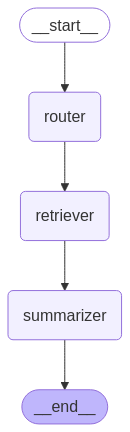

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))